In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import sagemaker_pyspark
import speech_recognition as sr
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField,StringType, FloatType
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import create_map, struct
from sagemaker_pyspark import classpath_jars
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
os.environ["PYTHONIOENCODING"] = "utf-8"

In [4]:
r = sr.Recognizer()

In [5]:
MODELED = 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\modeled\\'
#RAW = 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\raw\\'
RAW = 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\'

In [6]:
classpath = ":".join(sagemaker_pyspark.classpath_jars())

builder = SparkSession.builder.appName("MUSIC SPARK")
builder.config("spark.hadoop.mapreduce.fileoutputcommitter.algorithm.version", "2")
builder.config("spark.speculation", "false")
builder.config("spark.sql.parquet.compression.codec", "gzip")
builder.config("spark.debug.maxToStringFields", "100")
builder.config("spark.driver.extraClassPath", classpath)
builder.config("spark.driver.memory", "1g")
builder.config("spark.driver.cores", "1")
builder.config("spark.executor-memory", "20g")
builder.config("spark.executor.cores", "4")

builder.master("local[*]")

spark = builder.getOrCreate()
spark

In [7]:
all_music = [f'{RAW}{file}' for file in os.listdir(RAW) if '.wav' in file]
all_music

['F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (1).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (10).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (2).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (3).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (4).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (5).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (6).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (7).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (8).wav',
 'F:\\Sistema\\Downloads\\bigdatamusic_datas\\audios\\audio (9).wav']

In [8]:
with open(f'{MODELED}letters.csv', 'a') as letters:
    letters.write('name;text\n')

In [9]:
def music_letters(path):
    text = ''
    with sr.AudioFile(path) as source:
        
        """        
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
        except Exception as e:
            text = 'error'
        """ 
        
        audio = r.record(source)
        try:
            text = r.recognize_sphinx(audio)
        except Exception as e:
            text = 'error'
            
    return f'{path};{text}'

In [10]:
def write_music_in_csv(to_append):
    with open(f'{MODELED}letters.csv', 'a') as letters:
        letters.write(f'{to_append}\n')

In [11]:
pipe_music = spark.sparkContext.parallelize(all_music).map(music_letters).foreach(write_music_in_csv)

In [56]:
df = pd.read_csv(f'{MODELED}letters.csv', sep=';')
df.head()

,name,text
0,F:\Sistema\Downloads\bigdatamusic_datas\raw\ny...,mm and the half and if sons and it grows and a...
1,F:\Sistema\Downloads\bigdatamusic_datas\raw\PR...,in a tin can in nowhere in a handmade there to...
2,F:\Sistema\Downloads\bigdatamusic_datas\raw\HI...,that what you did all of these so what it usua...
3,F:\Sistema\Downloads\bigdatamusic_datas\raw\Au...,opted v. food during the a the didn't eighty t...
4,F:\Sistema\Downloads\bigdatamusic_datas\raw\wu...,and then no one who can in a car and then the ...


In [62]:
text = df.text[1]

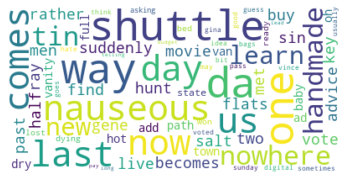

In [63]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(max_font_size=50, max_words=100, stopwords=stopwords, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [61]:
wordcloud.to_file(f'{MODELED}wordcloud.png')